Step 1: Set Up Environment

In [1]:
# Uncomment to pip install NLTK
#!pip install nltk

# Import core libraries
import pandas as pd
import numpy as np
import nltk
import re  # for regular expressions
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Import specific NLTK modules
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams

# Import scikit-learn text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Download necessary NLTK data
nltk.download('punkt')  # for tokenization
nltk.download('stopwords')  # common words without much meaning
nltk.download('wordnet')  # for lemmatization
nltk.download('averaged_perceptron_tagger')  # for POS tagging
nltk.download('vader_lexicon')  # for sentiment analysis

# Set visualization style
sns.set_style("whitegrid")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Step 2: Load and Examine Dataset

In [2]:
# Create a sample dataset of product reviews
reviews = [
    "This wireless keyboard is simply amazing! I've been using it for 3 months and the battery hasn't died yet. The keys have a satisfying click and the Bluetooth connection is flawless with my laptop and tablet.",
    "TERRIBLE PRODUCT! The headphones stopped working after just two weeks of normal use. The sound quality was mediocre at best when they did work. Customer service was unresponsive to my emails. Don't waste your money!",
    "I have mixed feelings about this camera. The picture quality is excellent in daylight, but low-light performance is disappointing. The menu system is unintuitive and takes time to learn. Battery life is decent, lasting about 4 hours of continuous shooting.",
    "The smartwatch exceeded my expectations! The health tracking features are spot-on, battery lasts nearly a week on a single charge, and it syncs perfectly with my phone. Worth every penny for fitness enthusiasts.",
    "DO NOT BUY THIS ROUTER!!! The signal drops constantly even in a small apartment. Setup was a nightmare and took over 2 hours with their confusing instructions. Complete waste of money - returning it tomorrow.",
    "This external hard drive is okay I guess. Transfer speeds are decent but not as fast as advertised. The build quality feels somewhat cheap, but it does the job of backing up my files. The included software is pretty useless though.",
    "Absolutely love this tablet! Fast processor, gorgeous display, and impressive battery life. Perfect for streaming Netflix and casual gaming. The stylus that comes with it is responsive and great for note-taking. Highly recommend for students!",
    "Disappointed with this Bluetooth speaker. While it looks sleek, the sound is tinny with almost no bass. The advertised 10-hour battery life is more like 6 hours at moderate volume. There are better options in this price range.",
    "The wireless earbuds are a solid 4/5 product. Sound quality is good though not audiophile level. They fit comfortably even during workouts and don't fall out. Battery lasts about 4 hours per charge, and the case provides 3 additional charges. The touch controls can be a bit finicky sometimes.",
    "This monitor has transformed my work-from-home setup! Crystal clear 4K resolution, accurate colors right out of the box, and the adjustable stand makes it easy to find the perfect viewing angle. The built-in speakers are surprisingly decent for a monitor.",
    "The gaming mouse I received was clearly used/refurbished despite being sold as new. There were scratches on the bottom and one of the programmable buttons was already stuck. When it worked, tracking was precise, but quality control is obviously an issue.",
    "I'm quite happy with this power bank. It charges my phone about 4-5 times before needing to be recharged itself. It's a bit bulky to carry in a pocket but fits fine in a bag. The dual USB ports are convenient for charging multiple devices simultaneously.",
    "This security camera has serious privacy issues. I discovered it was connecting to multiple unknown servers even after I disabled cloud features. Video quality is good and motion detection works well, but I can't trust it in my home.",
    "The mechanical keyboard is a joy to type on! The Cherry MX Blue switches provide satisfying tactile feedback, though they might be too loud for an office environment. RGB lighting is customizable and the aluminum construction feels premium. Minor complaint: the included wrist rest is too hard.",
    "Returned the WiFi extender after two days. It actually made my connection WORSE in some areas of the house. Setup appeared successful according to the app, but performance was abysmal. Save your money.",
    "This fitness tracker is a decent budget option. Step counting seems accurate, and the sleep tracking provides interesting insights. The app is basic but functional. Don't expect premium features, but it covers the essentials well enough for the price point.",
    "Very disappointed with this portable SSD. Transfer speeds nowhere near the advertised 1000MB/s - I'm lucky to get 400MB/s. The aluminum case does look nice and feels durable, but performance is what matters for storage devices.",
    "The noise-cancelling headphones are PERFECT for my daily commute on the subway! They block out almost all ambient noise, the sound quality is crisp and balanced, and they're comfortable for hours of wear. Battery life is impressive at around 25 hours per charge.",
    "This webcam is a massive letdown for professional video conferencing. Video quality is grainy unless your room is very brightly lit. The microphone picks up every little background noise. Considering the premium price, expected much better performance.",
    "I've been using this smartphone for about 2 months now. The camera system is exceptional, especially for night photography. Battery easily lasts a full day of heavy use. The only downsides are the bloatware that came pre-installed and the slightly uncomfortable edge design when using without a case."
]

# Create a DataFrame
df = pd.DataFrame({'review_text': reviews})

# Add a product category column for demonstration purposes
categories = ['Keyboard', 'Headphones', 'Camera', 'Smartwatch', 'Router', 
              'External Drive', 'Tablet', 'Bluetooth Speaker', 'Wireless Earbuds', 
              'Monitor', 'Mouse', 'Power Bank', 'Security Camera', 'Mechanical Keyboard', 
              'WiFi Extender', 'Fitness Tracker', 'Portable SSD', 'Noise-Cancelling Headphones', 
              'Webcam', 'Smartphone']
df['product_category'] = categories

# Add a rating column (1-5) based on sentiment analysis for demonstration
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def estimate_rating(text):
    score = sia.polarity_scores(text)['compound']
    if score <= -0.6:
        return 1
    elif score <= -0.2:
        return 2
    elif score <= 0.2:
        return 3
    elif score <= 0.6:
        return 4
    else:
        return 5

df['rating'] = df['review_text'].apply(estimate_rating)

# Examine the dataset
print(f"Dataset size: {len(df)} reviews")
print("\nRating distribution:")
print(df['rating'].value_counts().sort_index())

# Display the first few reviews with their categories and ratings
print("\nSample reviews:")
for i in range(3):
    print(f"\nCategory: {df['product_category'][i]} | Rating: {df['rating'][i]}/5")
    print(f"Review: {df['review_text'][i][:100]}...")

Dataset size: 20 reviews

Rating distribution:
rating
1     1
2     1
3     5
4     3
5    10
Name: count, dtype: int64

Sample reviews:

Category: Keyboard | Rating: 5/5
Review: This wireless keyboard is simply amazing! I've been using it for 3 months and the battery hasn't die...

Category: Headphones | Rating: 4/5
Review: TERRIBLE PRODUCT! The headphones stopped working after just two weeks of normal use. The sound quali...

Category: Camera | Rating: 2/5
Review: I have mixed feelings about this camera. The picture quality is excellent in daylight, but low-light...


Step 3: Text Decomposition through Tokenization

In [3]:
# Sentence tokenization
df['sentences'] = df['review_text'].apply(sent_tokenize)

# Word tokenization
df['tokens'] = df['review_text'].apply(word_tokenize)

# Calculate tokens per sentence
df['tokens_per_sentence'] = df.apply(lambda row: [len(word_tokenize(sentence)) for sentence in row['sentences']], axis=1)
df['avg_tokens_per_sentence'] = df['tokens_per_sentence'].apply(lambda x: sum(x)/len(x) if len(x) > 0 else 0)

# Examine tokenization results for a sample review
sample_idx = 2  # Third review
print(f"\nOriginal review (Product: {df['product_category'][sample_idx]}, Rating: {df['rating'][sample_idx]}/5):")
print(df['review_text'][sample_idx])

print("\nSentence tokens:")
for i, sentence in enumerate(df['sentences'][sample_idx]):
    print(f"  Sentence {i+1}: {sentence}")

print("\nFirst 15 word tokens:")
print(df['tokens'][sample_idx][:15])

print(f"\nTokens per sentence: {df['tokens_per_sentence'][sample_idx]}")
print(f"Average tokens per sentence: {df['avg_tokens_per_sentence'][sample_idx]:.2f}")


Original review (Product: Camera, Rating: 2/5):
I have mixed feelings about this camera. The picture quality is excellent in daylight, but low-light performance is disappointing. The menu system is unintuitive and takes time to learn. Battery life is decent, lasting about 4 hours of continuous shooting.

Sentence tokens:
  Sentence 1: I have mixed feelings about this camera.
  Sentence 2: The picture quality is excellent in daylight, but low-light performance is disappointing.
  Sentence 3: The menu system is unintuitive and takes time to learn.
  Sentence 4: Battery life is decent, lasting about 4 hours of continuous shooting.

First 15 word tokens:
['I', 'have', 'mixed', 'feelings', 'about', 'this', 'camera', '.', 'The', 'picture', 'quality', 'is', 'excellent', 'in', 'daylight']

Tokens per sentence: [8, 14, 11, 13]
Average tokens per sentence: 11.50


Step 4: Text Normalization and Standardization

In [4]:
# Create a more robust text normalization function
def normalize_text(tokens):
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation and non-alphabetic characters, but keep important ones like numbers
    # Keep tokens that have at least some alphanumeric content
    normalized = []
    for token in tokens:
        # Remove punctuation
        cleaned = re.sub(r'[^\w\s]', '', token)
        # Keep if there's something left after cleaning
        if cleaned and not cleaned.isspace():
            normalized.append(cleaned)
    
    return normalized

# Apply normalization
df['normalized_tokens'] = df['tokens'].apply(normalize_text)

# Compare original tokens with normalized tokens for a sample review
sample_idx = 9  # Tenth review
print(f"\nProduct: {df['product_category'][sample_idx]}, Rating: {df['rating'][sample_idx]}/5")
print("Original tokens (first 20):", df['tokens'][sample_idx][:20])
print("Normalized tokens (first 20):", df['normalized_tokens'][sample_idx][:20])

# Analyze changes made during normalization
original_tokens = df['tokens'][sample_idx]
normalized_tokens = df['normalized_tokens'][sample_idx]

# Find tokens that were removed or modified
modified_tokens = []
for i, token in enumerate(original_tokens):
    normalized = token.lower()
    normalized = re.sub(r'[^\w\s]', '', normalized)
    if normalized != token and normalized:
        modified_tokens.append((token, normalized))
    elif not normalized and token:
        modified_tokens.append((token, "[REMOVED]"))
        
print("\nModifications made during normalization (first 10):")
for original, modified in modified_tokens[:10]:
    print(f"  '{original}' → '{modified}'")


Product: Monitor, Rating: 5/5
Original tokens (first 20): ['This', 'monitor', 'has', 'transformed', 'my', 'work-from-home', 'setup', '!', 'Crystal', 'clear', '4K', 'resolution', ',', 'accurate', 'colors', 'right', 'out', 'of', 'the', 'box']
Normalized tokens (first 20): ['this', 'monitor', 'has', 'transformed', 'my', 'workfromhome', 'setup', 'crystal', 'clear', '4k', 'resolution', 'accurate', 'colors', 'right', 'out', 'of', 'the', 'box', 'and', 'the']

Modifications made during normalization (first 10):
  'This' → 'this'
  'work-from-home' → 'workfromhome'
  '!' → '[REMOVED]'
  'Crystal' → 'crystal'
  '4K' → '4k'
  ',' → '[REMOVED]'
  ',' → '[REMOVED]'
  '.' → '[REMOVED]'
  'The' → 'the'
  'built-in' → 'builtin'


Step 5: Stopword Removal

In [5]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

# Print some examples of stopwords
print("Sample stopwords:", list(stop_words)[:15])

# Function to remove stopwords
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

# Apply stopword removal
df['filtered_tokens'] = df['normalized_tokens'].apply(remove_stopwords)

# Compare before and after for a sample review
sample_idx = 6  # Seventh review
print(f"\nProduct: {df['product_category'][sample_idx]}, Rating: {df['rating'][sample_idx]}/5")
print("Before stopword removal (first 20):", df['normalized_tokens'][sample_idx][:20])
print("After stopword removal (first 20):", df['filtered_tokens'][sample_idx][:20])

# Analyze the impact of stopword removal
original_count = len(df['normalized_tokens'][sample_idx])
filtered_count = len(df['filtered_tokens'][sample_idx])
reduction_percent = ((original_count - filtered_count) / original_count) * 100

print(f"\nStopword removal reduced token count from {original_count} to {filtered_count} ({reduction_percent:.1f}% reduction)")

# Find the removed stopwords for this review
removed_words = [word for word in df['normalized_tokens'][sample_idx] if word in stop_words]
print(f"Removed stopwords (first 10): {removed_words[:10]}")

# Calculate average reduction across all reviews
all_normalized = sum(df['normalized_tokens'].apply(len))
all_filtered = sum(df['filtered_tokens'].apply(len))
avg_reduction = ((all_normalized - all_filtered) / all_normalized) * 100
print(f"\nAverage token reduction across all reviews: {avg_reduction:.1f}%")

Sample stopwords: ['from', 'out', 'above', 'on', 'same', 'being', 'have', 'himself', 'this', 'hadn', 'was', 'yourself', 'nor', "weren't", 'doesn']

Product: Tablet, Rating: 5/5
Before stopword removal (first 20): ['absolutely', 'love', 'this', 'tablet', 'fast', 'processor', 'gorgeous', 'display', 'and', 'impressive', 'battery', 'life', 'perfect', 'for', 'streaming', 'netflix', 'and', 'casual', 'gaming', 'the']
After stopword removal (first 20): ['absolutely', 'love', 'tablet', 'fast', 'processor', 'gorgeous', 'display', 'impressive', 'battery', 'life', 'perfect', 'streaming', 'netflix', 'casual', 'gaming', 'stylus', 'comes', 'responsive', 'great', 'notetaking']

Stopword removal reduced token count from 35 to 23 (34.3% reduction)
Removed stopwords (first 10): ['this', 'and', 'for', 'and', 'the', 'that', 'with', 'it', 'is', 'and']

Average token reduction across all reviews: 40.0%


Step 6: Stemming and Lemmatization

In [6]:
# Initialize stemmers and lemmatizer
porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    '''Translate nltk POS to wordnet tags'''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Porter Stemming function
def porter_stem_tokens(tokens):
    return [porter_stemmer.stem(token) for token in tokens]

# Snowball Stemming function (alternative algorithm)
def snowball_stem_tokens(tokens):
    return [snowball_stemmer.stem(token) for token in tokens]

# Lemmatization function with POS tagging
def lemmatize_tokens(tokens):
    # First, make sure we only tag actual words (sometimes filtered tokens can be just numbers)
    # This avoids POS tagging errors
    valid_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Tag with parts of speech
    tokens_tagged = pos_tag(valid_tokens)
    
    # Get wordnet POS tags
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]
    
    # Lemmatize with POS tags
    lemmatized = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    
    # Add back any tokens that weren't processed (like numbers)
    unprocessed = [token for token in tokens if token not in valid_tokens]
    
    return lemmatized + unprocessed

# Apply stemming and lemmatization
df['porter_stemmed'] = df['filtered_tokens'].apply(porter_stem_tokens)
df['snowball_stemmed'] = df['filtered_tokens'].apply(snowball_stem_tokens)
df['lemmatized'] = df['filtered_tokens'].apply(lemmatize_tokens)

# Compare results for a sample review
sample_idx = 3  # Fourth review
print(f"\nProduct: {df['product_category'][sample_idx]}, Rating: {df['rating'][sample_idx]}/5")
print("\nFiltered tokens (first 10):", df['filtered_tokens'][sample_idx][:10])
print("Porter stemming (first 10):", df['porter_stemmed'][sample_idx][:10])
print("Snowball stemming (first 10):", df['snowball_stemmed'][sample_idx][:10])
print("Lemmatization (first 10):", df['lemmatized'][sample_idx][:10])

# Detailed comparison of stemming vs lemmatization for selected words
comparison_words = ['running', 'better', 'worse', 'good', 'studies', 'studying', 
                    'batteries', 'easily', 'performance', 'disappointing']

print("\nDetailed comparison of stemming vs. lemmatization:")
print(f"{'Original':<15} {'Porter Stem':<15} {'Snowball Stem':<15} {'Lemmatized':<15}")
print("-" * 60)
for word in comparison_words:
    porter = porter_stemmer.stem(word)
    snowball = snowball_stemmer.stem(word)
    lemma = lemmatizer.lemmatize(word, wordnet.VERB)  # Assume verb for this example
    print(f"{word:<15} {porter:<15} {snowball:<15} {lemma:<15}")


Product: Smartwatch, Rating: 5/5

Filtered tokens (first 10): ['smartwatch', 'exceeded', 'expectations', 'health', 'tracking', 'features', 'spoton', 'battery', 'lasts', 'nearly']
Porter stemming (first 10): ['smartwatch', 'exceed', 'expect', 'health', 'track', 'featur', 'spoton', 'batteri', 'last', 'nearli']
Snowball stemming (first 10): ['smartwatch', 'exceed', 'expect', 'health', 'track', 'featur', 'spoton', 'batteri', 'last', 'near']
Lemmatization (first 10): ['smartwatch', 'exceed', 'expectation', 'health', 'track', 'feature', 'spoton', 'battery', 'last', 'nearly']

Detailed comparison of stemming vs. lemmatization:
Original        Porter Stem     Snowball Stem   Lemmatized     
------------------------------------------------------------
running         run             run             run            
better          better          better          better         
worse           wors            wors            worse          
good            good            good            good  

Step 7: N-gram Analysis for Context

In [7]:
# Function to generate multiple n-grams
def generate_ngrams_multiple(tokens, n_values):
    result = {}
    for n in n_values:
        result[f'{n}-grams'] = list(ngrams(tokens, n))
    return result

# Generate n-grams for each review
n_values = [2, 3]  # Bigrams and trigrams
df['ngrams'] = df['lemmatized'].apply(lambda x: generate_ngrams_multiple(x, n_values))

# Examine n-grams for a sample review
sample_idx = 17  # 18th review
print(f"\nProduct: {df['product_category'][sample_idx]}, Rating: {df['rating'][sample_idx]}/5")
print("\nLemmatized tokens (first 15):", df['lemmatized'][sample_idx][:15])

print("\nBigrams (first 10):")
for i, bigram in enumerate(df['ngrams'][sample_idx]['2-grams'][:10]):
    print(f"  {i+1}. {bigram}")

print("\nTrigrams (first 10):")
for i, trigram in enumerate(df['ngrams'][sample_idx]['3-grams'][:10]):
    print(f"  {i+1}. {trigram}")

# Analyze frequency of bigrams across all reviews
all_bigrams = []
for ngram_dict in df['ngrams']:
    all_bigrams.extend(ngram_dict['2-grams'])

# Count and display the most common bigrams
bigram_counts = Counter(all_bigrams)
print("\nMost common bigrams across all reviews:")
for bigram, count in bigram_counts.most_common(10):
    print(f"  {bigram}: {count} occurrences")


Product: Noise-Cancelling Headphones, Rating: 5/5

Lemmatized tokens (first 15): ['noisecancelling', 'headphone', 'perfect', 'daily', 'commute', 'subway', 'block', 'almost', 'ambient', 'noise', 'sound', 'quality', 'crisp', 'balance', 'comfortable']

Bigrams (first 10):
  1. ('noisecancelling', 'headphone')
  2. ('headphone', 'perfect')
  3. ('perfect', 'daily')
  4. ('daily', 'commute')
  5. ('commute', 'subway')
  6. ('subway', 'block')
  7. ('block', 'almost')
  8. ('almost', 'ambient')
  9. ('ambient', 'noise')
  10. ('noise', 'sound')

Trigrams (first 10):
  1. ('noisecancelling', 'headphone', 'perfect')
  2. ('headphone', 'perfect', 'daily')
  3. ('perfect', 'daily', 'commute')
  4. ('daily', 'commute', 'subway')
  5. ('commute', 'subway', 'block')
  6. ('subway', 'block', 'almost')
  7. ('block', 'almost', 'ambient')
  8. ('almost', 'ambient', 'noise')
  9. ('ambient', 'noise', 'sound')
  10. ('noise', 'sound', 'quality')

Most common bigrams across all reviews:
  ('battery', 'l

Step 8: Sentiment Analysis


Sample reviews:

Initial Rating: 5 | New Rating: 4/5
Review: This wireless keyboard is simply amazing! I've been using it for 3 months and the battery hasn't die...

Initial Rating: 4 | New Rating: 1/5
Review: TERRIBLE PRODUCT! The headphones stopped working after just two weeks of normal use. The sound quali...

Initial Rating: 2 | New Rating: 1/5
Review: I have mixed feelings about this camera. The picture quality is excellent in daylight, but low-light...

Agreement between initial rating and sentiment-predicted rating: 25.0%


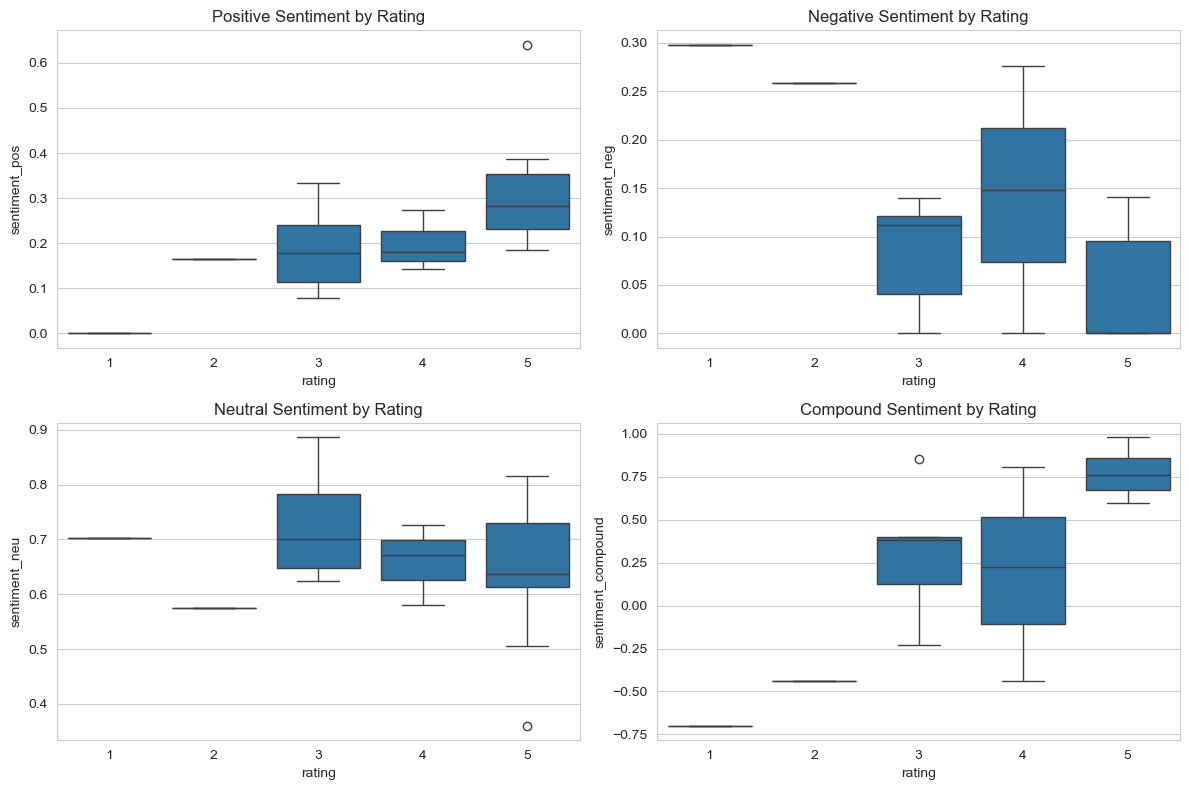


Examples where sentiment analysis disagrees with the initial uncleaned rating:

Product: Keyboard
Actual Rating: 5/5
Predicted Rating: 4/5
Sentiment Compound Score: 0.71
Review excerpt: This wireless keyboard is simply amazing! I've been using it for 3 months and the battery hasn't die...

Product: Headphones
Actual Rating: 4/5
Predicted Rating: 1/5
Sentiment Compound Score: -0.44
Review excerpt: TERRIBLE PRODUCT! The headphones stopped working after just two weeks of normal use. The sound quali...

Product: Camera
Actual Rating: 2/5
Predicted Rating: 1/5
Sentiment Compound Score: -0.44
Review excerpt: I have mixed feelings about this camera. The picture quality is excellent in daylight, but low-light...


In [8]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()


# Join lemmatized tokens back to text
df['preprocessed_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))


# Calculate detailed sentiment scores
df['sentiment_scores'] = df['preprocessed_text'].apply(lambda x: sia.polarity_scores(x))


# Extract individual sentiment components
df['sentiment_neg'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['sentiment_neu'] = df['sentiment_scores'].apply(lambda x: x['neu'])
df['sentiment_pos'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['sentiment_compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])


# Classify sentiment based on compound score
df['sentiment'] = df['sentiment_compound'].apply(
   lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)


# Calculate agreement between sentiment and rating
df['predicted_rating'] = df['sentiment_compound'].apply(
   lambda x: 5 if x > 0.9 else (
             4 if x > 0.6 else (
             3 if x > 0.2 else (
             2 if x > 0.0 else 1)))
)


# Display the first few reviews with their initial ratings and predicted ratings after preprocessing
print("\nSample reviews:")
for i in range(3):
   print(f"\nInitial Rating: {df['rating'][i]} | New Rating: {df['predicted_rating'][i]}/5")
   print(f"Review: {df['review_text'][i][:100]}...")


agreement = (df['rating'] == df['predicted_rating']).mean() * 100
print(f"\nAgreement between initial rating and sentiment-predicted rating: {agreement:.1f}%")


# Visualize the relationship between sentiment scores and ratings
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x='rating', y='sentiment_pos', data=df)
plt.title('Positive Sentiment by Rating')


plt.subplot(2, 2, 2)
sns.boxplot(x='rating', y='sentiment_neg', data=df)
plt.title('Negative Sentiment by Rating')


plt.subplot(2, 2, 3)
sns.boxplot(x='rating', y='sentiment_neu', data=df)
plt.title('Neutral Sentiment by Rating')


plt.subplot(2, 2, 4)
sns.boxplot(x='rating', y='sentiment_compound', data=df)
plt.title('Compound Sentiment by Rating')


plt.tight_layout()
plt.show()


# Analyze mismatches between sentiment and rating
mismatches = df[df['rating'] != df['predicted_rating']]
if len(mismatches) > 0:
   print("\nExamples where sentiment analysis disagrees with the initial uncleaned rating:")
   for i, row in mismatches.head(3).iterrows():
       print(f"\nProduct: {row['product_category']}")
       print(f"Actual Rating: {row['rating']}/5")
       print(f"Predicted Rating: {row['predicted_rating']}/5")
       print(f"Sentiment Compound Score: {row['sentiment_compound']:.2f}")
       print(f"Review excerpt: {row['review_text'][:100]}...")

Step 9: Pipeline validation and Refinement


Vocabulary size comparison:
  minimal: 435 unique tokens
  standard: 348 unique tokens
  with_bigrams: 449 unique tokens
  no_stopword_removal: 402 unique tokens

Average tokens per review:
  minimal: 45.2 tokens
  standard: 24.1 tokens
  with_bigrams: 23.1 tokens
  no_stopword_removal: 40.0 tokens


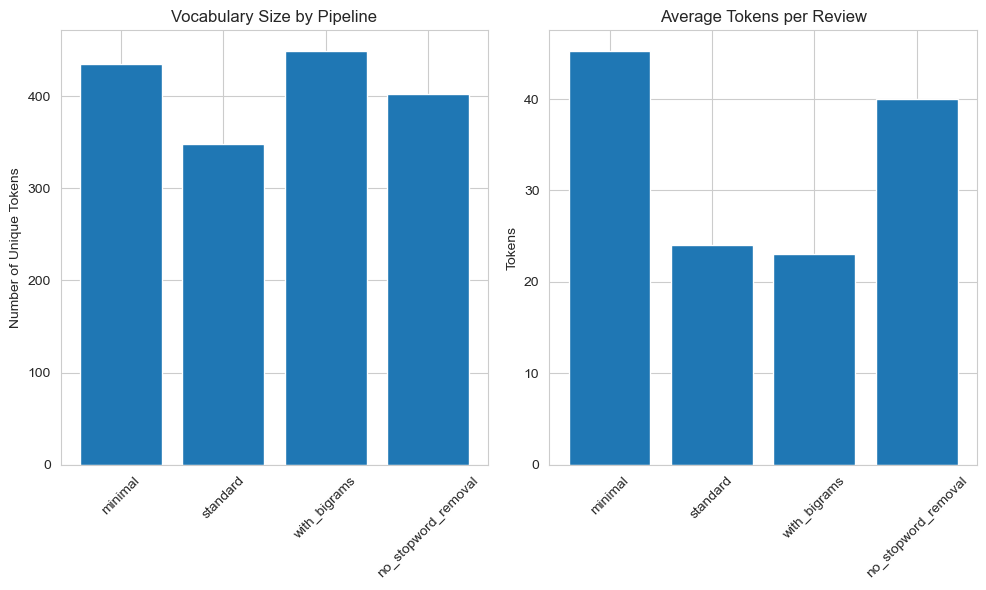

In [9]:
# Create different preprocessing pipelines to compare
pipelines = {
   'minimal': df['tokens'].apply(lambda x: [token.lower() for token in x]),
   'standard': df['lemmatized'],
   'with_bigrams': df['ngrams'].apply(lambda x: list(x['2-grams'])),
   'no_stopword_removal': df['normalized_tokens'].apply(lemmatize_tokens)
}


# Calculate vocabulary size for each pipeline
vocab_sizes = {}


for k,v in pipelines.items():
   tokens = []
   for doc in v:
       tokens.extend(doc)
   length = len(set(tokens))
   vocab_sizes[k] = length


# Print vocabulary sizes
print("\nVocabulary size comparison:")
for name, size in vocab_sizes.items():
   print(f"  {name}: {size} unique tokens")


# Analyze information retention
# Calculate average tokens per review for each pipeline
avg_tokens = {name: np.mean([len(tokens) for tokens in pipeline])
             for name, pipeline in pipelines.items()}


print("\nAverage tokens per review:")
for name, avg in avg_tokens.items():
   print(f"  {name}: {avg:.1f} tokens")


# Visualize the impact of preprocessing choices
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(vocab_sizes.keys(), vocab_sizes.values())
plt.title('Vocabulary Size by Pipeline')
plt.xticks(rotation=45)
plt.ylabel('Number of Unique Tokens')


plt.subplot(1, 2, 2)
plt.bar(avg_tokens.keys(), avg_tokens.values())
plt.title('Average Tokens per Review')
plt.xticks(rotation=45)
plt.ylabel('Tokens')


plt.tight_layout()
plt.show()